# Classification and Regression Metrics

*Hayley Boyce, May 17th, 2021*

In [1]:
# Importing our libraries
import pandas as pd
import altair as alt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVR, SVC
from sklearn import datasets

import sys
sys.path.append('code/')
from display_tree import display_tree
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

import scipy
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## House Keeping 
- Big lecture today!
- Last class on Wednesday. 
- Assignment 3 due on Wednesday.
- [My Twitter](https://twitter.com/HayleyFBoyce)
- Question 3.2 -> most informative negative words
- Project clarification (If you have a "How" business question) 

## Lecture Learning Objectives 

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix.
- Define precision, recall, and f1-score and use them to evaluate different classifiers.
- Identify whether there is class imbalance and whether you need to deal with it.
- Explain `class_weight` and use it to deal with data imbalance.
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems. MSE, RMSE, $R^2$, MAPE.
- Apply different scoring functions with `cross_validate`, `GridSearchCV` and `RandomizedSearchCV`.

## Five Minute Recap/ Lightning Questions 

- What are the 2 types of feature selection methods we saw last class?
- What is the name of the function that helps us discover features that potentially contribute to our model in Decision Trees (and other models too)
- In a decision tree, where can we see the "most important" feature of the model in the structure?
- Should we ever question our clients' requests? 

### Some lingering questions

- What happens if we have data where there is a lot of one class and very few of another?
- How can we measure our model's success besides using accuracy or $R2$?

## Introducing Evaluation Metrics 

Up until this point, we have been scoring our models the same way every time.

We've been using the percentage of correctly predicted examples for classification problems and the $R^2$ metric for regression problems.

Let's discuss how we need to expand our horizons and why it's important to evaluate our models in other ways.

To help explain why accuracy isn't always the most beneficial option, we are bringing in a new dataset.

You've actually seen this data at the very beginning of this course in lecture 1 but it was just a subset of the entire data.

Please download the data from Kaggle here and put it in the data folder used for the lectures.

In [2]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)

In [3]:
train_df.head()

Time        V1        V2        V3        V4        V5        V6  \
64454    51150.0 -3.538816  3.481893 -1.827130 -0.573050  2.644106 -0.340988   
37906    39163.0 -0.363913  0.853399  1.648195  1.118934  0.100882  0.423852   
79378    57994.0  1.193021 -0.136714  0.622612  0.780864 -0.823511 -0.706444   
245686  152859.0  1.604032 -0.808208 -1.594982  0.200475  0.502985  0.832370   
60943    49575.0 -2.669614 -2.734385  0.662450 -0.059077  3.346850 -2.549682   

              V7        V8        V9  ...       V21       V22       V23  \
64454   2.102135 -2.939006  2.578654  ...  0.530978 -0.860677 -0.201810   
37906   0.472790 -0.972440  0.033833  ...  0.687055 -0.094586  0.121531   
79378  -0.206073 -0.016918  0.781531  ... -0.310405 -0.842028  0.085477   
245686 -0.034071  0.234040  0.550616  ...  0.519029  1.429217 -0.139322   
60943  -1.430571 -0.118450  0.469383  ... -0.228329 -0.370643 -0.211544   

             V24       V25       V26       V27       V28  Amount  Class  
64454  -1.719747  0.729143 -0.547993 -0.023636 -0.454966    1.00      0  
37906   0.146830 -0.944092 -0.558564 -0.186814 -0.257103   18.49      0  
79378   0.366005  0.254443  0.290002 -0.036764  0.015039   23.74      0  
245686 -1.293663  0.037785  0.061206  0.005387 -0.057296  156.52      0  
60943  -0.300837 -1.174590  0.573818  0.388023  0.161782   57.50      0  

[5 rows x 31 columns]

In [4]:
train_df.shape

(199364, 31)

We can see this is a large dataset with 199364 examples and 31 features in our training set.

Hence why I can't distribute it - it's too big! 

In [5]:
train_df.describe(include="all", percentiles = [])

Time             V1             V2             V3  \
count  199364.000000  199364.000000  199364.000000  199364.000000   
mean    94888.815669       0.000492      -0.000726       0.000927   
std     47491.435489       1.959870       1.645519       1.505335   
min         0.000000     -56.407510     -72.715728     -31.813586   
50%     84772.500000       0.018854       0.065463       0.179080   
max    172792.000000       2.451888      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  199364.000000  199364.000000  199364.000000  199364.000000   
mean        0.000630       0.000036       0.000011      -0.001286   
std         1.413958       1.361718       1.327188       1.210001   
min        -5.683171     -42.147898     -26.160506     -43.557242   
50%        -0.019531      -0.056703      -0.275290       0.040497   
max        16.491217      34.801666      23.917837      44.054461   

                  V8             V9  ...            V21            V22  \
count  199364.000000  199364.000000  ...  199364.000000  199364.000000   
mean       -0.002889      -0.000891  ...       0.001205       0.000155   
std         1.214852       1.096927  ...       0.748510       0.726634   
min       -73.216718     -13.320155  ...     -34.830382      -8.887017   
50%         0.022039      -0.052607  ...      -0.029146       0.007666   
max        19.587773      15.594995  ...      27.202839      10.503090   

                 V23            V24            V25            V26  \
count  199364.000000  199364.000000  199364.000000  199364.000000   
mean       -0.000198       0.000113       0.000235       0.000312   
std         0.628139       0.605060       0.520857       0.481960   
min       -44.807735      -2.824849     -10.295397      -2.241620   
50%        -0.011678       0.041031       0.016587      -0.052790   
max        22.083545       4.022866       6.070850       3.517346   

                 V27            V28         Amount          Class  
count  199364.000000  199364.000000  199364.000000  199364.000000  
mean       -0.000366       0.000227      88.164679       0.001700  
std         0.401541       0.333139     238.925768       0.041201  
min       -22.565679     -11.710896       0.000000       0.000000  
50%         0.001239       0.011234      22.000000       0.000000  
max        12.152401      33.847808   11898.090000       1.000000  

[6 rows x 31 columns]

We see that the columns are all scaled and numerical.

You don't need to worry about this now. The original columns have been transformed already for confidentiality and our benefit so now there are no categorical features.

Let's separate `X` and `y` for train and test splits.

In [6]:
X_train_big, y_train_big = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]



We are going to be talking about evaluation metrics and it's easier to do so if we use an explicit validation set instead of using cross-validation.

Our data is large enough so it shouldn't be a problem.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big,  y_train_big, test_size=0.3, random_state=123)

### Baseline

Just like and predictive question, we start our analysis by building a simple `DummyClassifier` model as our baseline.

In [8]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.9983017326626252

In [9]:
dummy.score(X_valid, y_valid)

0.9982945995652901

Hang on, what is going on?

99.8% accuracy? This is supposed to be a baseline model! How is it getting such high accuracy? 

Should we just deploy this `DummyClassifier` model for fraud detection?


In [10]:
train_df["Class"].value_counts(normalize=True)

0    0.9983
1    0.0017
Name: Class, dtype: float64

If we look at the distribution of fraudulent labels to non-fraudulent labels, we can see there is an imbalance in the classes. 

Here the `0` class is a Non fraud transaction, and the `1` class is a Fraud transaction. 

We can see here that there are MANY Non fraud transactions and only a tiny handful of Fraud transactions.

So, what would be a good accuracy here? 99.9%? 99.99%?

The "Fraud" class is the class that we want to spot. The class we are interested in. 

We can make a model better than the dummy classifier now.

In [11]:
pipe = make_pipeline(
       (StandardScaler()),
       (LogisticRegression(random_state=123))
)

In [12]:
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.590032
score_time     0.011000
test_score     0.999176
train_score    0.999249
dtype: float64

This seems slightly better than `DummyClassifier`, but the question is can it really identify fraudulent transactions?

This model will cover new tools on how to measure this. 

## Classification Metrics and tools

### What is "positive" and "negative"?

There are two kinds of binary classification problems:

- Distinguishing between two classes
- Spotting a specific class (fraud transaction, spam, disease)


We saw in logistic regression that the model designates a positive and negative class alphabetically when classifying observation but here when we are designating a positive and negative class, we need to be a bit more thoughtful. 

In the case of spotting problems, the thing that we are interested in spotting is considered "positive". 

In our example, we want to spot **fraudulent** transactions and so fraudulent is the "positive" class. 


### Confusion Matrix

A **confusion matrix** is a table that visualizes the performance of an algorithm. It shows the possible labels and how many of each label the model predicts correctly and incorrectly. 

We can import `plot_confusion_matrix` from `sklearn.metrics`.

In [13]:
from sklearn.metrics import  plot_confusion_matrix

In [14]:
pipe.fit(X_train, y_train);

Once we fit on our training portion, we can use the `plot_confusion_matrix` function to see how well our model is doing classifying each target class.

In this case, we are looking at the validation portion only. 

This results in a 2 by 2 matrix with the labels `Non fraud` and `Fraud` on each axis. 

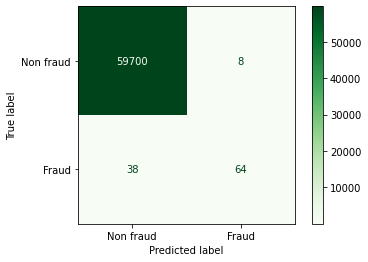

In [15]:
plot_confusion_matrix(pipe, X_valid, y_valid, 
                      display_labels=["Non fraud", "Fraud"],
                      values_format="d",
                      cmap="Greens");

**Looking at the arguments:**

Similar to other `sklearn` functions, we can the model/pipeline followed by the feature table and then the target value objects. 

`display_labels` will show more descriptive labels. without this argument, it would simply show the classes we have in the data (`0`, `1`). 

`values_format` will determine how the numbers are displayed. Specifying `d` avoids scientific notation. 

`cmap` is the colour argument! The default is `viridis` but other values such as `Blues`, `Purples`, `RdPu` or other colour schemes from [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html) are also possible. 

#### Confusion Matrix components

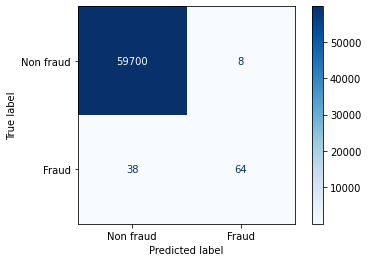

In [16]:
plot_confusion_matrix(pipe, X_valid, y_valid, 
                      display_labels=["Non fraud", "Fraud"],
                      values_format="d", cmap="Blues");

|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |


Remember the Fraud is considered "positive" in this case and Non fraud is considered "negative". 


The 4 quadrants of the confusion matrix can be explained as follows. These positions will change depending on what values we deem as the positive label. 

- **True negative (TN)**: Examples that are negatively labelled that the model correctly predicts. This is in the top left quadrant. 
- **False positive (FP)**: Examples that are negatively labelled that the model incorrectly predicts as positive. This is in the top right quadrant. 
- **False negative (FN)**:  Examples that are positively labelled that the model incorrectly predicts as negative. This is in the bottom left quadrant. 
- **True positive (TP)**:  Examples that are positively labelled that the model correctly predicted as positive. This is in the bottom right quadrant. 

If you want something more numeric and simpler you can obtain a NumPy array by importing `confusion_matrix` from the sklearn library. (Before we were importing `plot_confusion_matrix`)

In [17]:
from sklearn.metrics import confusion_matrix

Here we get the predictions of the model first with `.predict()` and compare it with `y_valid` in the function `confusion_matrix()`.

In [18]:
predictions = pipe.predict(X_valid)
confusion_matrix(y_valid, predictions)

array([[59700,     8],
       [   38,    64]])

### Accuracy is only part of the story...

We have been using `.score` to assess our models, which returns accuracy by default. 

And we saw that accuracy can be  misleading when we have a class imbalance.

We need other metrics to assess our models.

Note that the metrics we are going to discuss will only help us assess our model but further into this lecture we'll talk about a few ways to address the class imbalance problem as well. 

Let's build our pipeline, and fit it. Once we've done that, we can create our confusion matrix.

In [19]:
pipe.fit(X_train,y_train);
predictions = pipe.predict(X_valid)
confusion_matrix(y_valid, predictions)

array([[59700,     8],
       [   38,    64]])

This time we are going to split up the values in the matrix into the 4 quadrants we saw earlier. 

- `TN` for the True Negatives
- `FP` for the False Positives
- `FN` for the False Negatives
- `TP` for the True Positives 

We need each of these values to explain the next measurements.

In [20]:
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).flatten()

### Recall 

*"Among all positive examples, how many did you identify?"*

$$ \text{recall} = \frac{TP}{TP + FN} = \frac{\text{Number of correctly identified positives}}{\text{Total number of true positives}}$$

**Recall**: how many of the actual positive examples did you identify?

Since Fraud is our positive label, we see the correctly identified labels in the bottom right quadrant and the ones that we missed in the bottom left quadrant. 

<img src='imgs/recall.png' width="50%"> 

$ \text{recall} = \frac{TP}{TP + FN}$

So here we take our true positives and we divide by all the positive labels in our validation set (the predictions the model incorrectly labelled as negative (the false negatives) as well as those correctly labelled as positive). 

In [21]:
print('True Positives:', TP)
print('False Negatives:', FN)

True Positives: 64
False Negatives: 38


In [22]:
recall = TP / (TP + FN)
recall.round(4)

0.6275

### Precision

*"Among the positive examples you identified, how many were actually positive?"*

$$ \text{precision} = \frac{TP}{TP + FP} = \frac{\text{Number of correctly identified positives}}{\text{Total number of predicted positives}}$$

**Precision**:  Of the Frauds we "caught", the fraction that was actually fraudulent.

With Fraud as our positive label,  we see the correctly identified Fraudulent cases in the bottom right quadrant and the labels we incorrectly labelled as Frauds in the top right. 

<img src='imgs/precision.png' width="50%"> 

$ \text{recall} = \frac{TP}{TP + FP}$

So here we take our true positives and we divide by all the positive labels that our model predicted. 

In [23]:
print('True Positives:', TP)
print('False Positives:', FP)

True Positives: 64
False Positives: 8


In [24]:
precision = TP / (TP + FP)
precision.round(4)

0.8889

Of course, we'd like to have high precision and recall but the balance depends on our domain.

For credit card fraud detection, recall is really important (catching frauds), precision is less important (reducing false positives).

### f1 score

Sometimes we need a single score to maximize, e.g., when doing hyperparameter tuning via RandomizedSearchCV.

Accuracy is often a bad choice.

*f1-score combines precision and recall to give one score.*

$$ \text{f1} = 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}} $$

**f1**: The harmonic mean of precision and recall. 


If both precision and recall go up, the f1 score will go up, so in general, we want this to be high.

In [25]:
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))

Precision: 0.8889
Recall: 0.6275


In [26]:
f1_score = (2 * precision * recall) / (precision + recall)
f1_score.round(4)

0.7356

We could calculate all these evaluation metrics by hand: 

In [27]:
data = {}
data["accuracy"] = [(TP + TN) / (TN + FP + FN + TP)]
data["error"] = [(FP + FN) / (TN + FP + FN + TP)]
data["precision"] = [ TP / (TP + FP)] 
data["recall"] = [TP / (TP + FN)] 
data["f1 score"] = [(2 * precision * recall) / (precision + recall)] 

measures_df = pd.DataFrame(data, index=['ourselves'])
measures_df

accuracy     error  precision    recall  f1 score
ourselves  0.999231  0.000769   0.888889  0.627451  0.735632

... or we can use `scikit-learn` which has functions for these metrics.

Here we are importing `accuracy_score`, `precision_score`, `recall_score`, `f1_score` from `sklearn.metrics`

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
pred_cv =  pipe.predict(X_valid) 

data["accuracy"].append(accuracy_score(y_valid, pred_cv))
data["error"].append(1 - accuracy_score(y_valid, pred_cv))
data["precision"].append(precision_score(y_valid, pred_cv, zero_division=1))
data["recall"].append(recall_score(y_valid, pred_cv))
data["f1 score"].append(f1_score(y_valid, pred_cv))

pd.DataFrame(data, index=['ourselves', 'sklearn'])

accuracy     error  precision    recall  f1 score
ourselves  0.999231  0.000769   0.888889  0.627451  0.735632
sklearn    0.999231  0.000769   0.888889  0.627451  0.735632

And you can see the scores match. 

We can even go one step further and "observe" the scores using a *Classification report* 

### Classification report 

Similar to how a confusion matrix shows the False and True negative and positive labels, a classification report shows us an assortment of metrics, however, we can't flatten or obtain the results from it and only see what is printed as the output. 

We can import `classification_report` from `sklearn.metrics`

In [30]:
from sklearn.metrics import classification_report

We can use `classes` to see which position each label takes so we can designate them more comprehensive labels in our report. 

In [31]:
pipe.classes_

array([0, 1])

In our function, we specify the true labels, followed by the predictions our model made. 

The argument `target_names`, gives more descriptive labels similar to what `display_labels` did in `plot_confusion_matrix`. 

In [32]:
print(classification_report(y_valid, pipe.predict(X_valid),
                            target_names=["non fraud", "Fraud"]))

              precision    recall  f1-score   support

   non fraud       1.00      1.00      1.00     59708
       Fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



Note that what you consider "positive" (Fraud in our case) is important when calculating precision, recall, and f1-score. 

If you flip what is considered positive or negative, we'll end up with different True Positive, False Positive, True Negatives and False Negatives, and hence different precision, recall, and f1-scores. 

The `support` column just shows the number of examples in each class.  


You might also be wondering about 2 additional metrics in this report...

#### Macro average vs weighted average

These metrics are more useful when predicting multiple classes which we will briefly discuss later on. 

**Macro average** is useful when you want to give equal importance to all classes irrespective of the number of instances in each class.

**Weighted average** gives equal importance to all examples. So, when you care about the overall score and do not care about the score on a specific class, you could use it.

Which one is relevant, depends upon whether you think each class should have the same weight or each sample should have the same weight. 

In addition to this lecture, my wonderful colleague [Varada Kolhatkar](https://kvarada.github.io/) has made a cheat sheet for these metrics available in a larger size [here](https://raw.githubusercontent.com/UBC-MDS/introduction-machine-learning/master/static/module7/evaluation-metrics.png).

<img src="https://raw.githubusercontent.com/UBC-MDS/introduction-machine-learning/master/static/module7/evaluation-metrics.png"  width = "70%" alt="404 image" />

### Imbalanced datasets

A class imbalance typically refers to having many more examples of one class than another in one's training set.

We've seen this in our fraud dataset where our `class` target column had many more non-fraud than fraud examples. 

Real-world data is often imbalanced and can be seen in scenarios such as:

- Ad clicking data (Only around ~0.01% of ads are clicked.)
- Spam classification datasets.


In [33]:
X_train.head()

Time        V1        V2        V3        V4        V5        V6  \
80437    58486.0  0.984032 -1.851494  0.670618 -1.192458 -2.092441 -0.511208   
60984    49594.0 -0.985503  1.429365  1.528503  0.786004 -0.467397 -0.298816   
128056   78583.0 -1.205750  0.892452  2.380624 -0.016385 -0.442344  0.312907   
71109    54160.0 -1.221491  0.584432  0.260960 -2.183469  0.148069 -0.353845   
172062  120937.0  2.108906 -0.036505 -1.729322 -0.006799  0.594977 -0.414454   

              V7        V8        V9  ...       V20       V21       V22  \
80437  -1.014356 -0.088517 -1.947026  ...  0.187838  0.151899  0.293799   
60984   0.080549  0.464257 -1.157092  ...  0.255637 -0.129198 -0.451259   
128056  0.158987  0.048223  0.990212  ...  0.192520 -0.072519  0.168212   
71109   0.134643  0.220526 -1.162636  ...  0.444476  0.182635  0.720601   
172062  0.167962 -0.220672  0.330188  ... -0.166839  0.231473  0.833535   

             V23       V24       V25       V26       V27       V28  Amount  
80437  -0.200566  0.548729  0.207097 -0.159589  0.005833  0.061062  249.00  
60984  -0.104275  0.346654 -0.039245  0.367483  0.049164  0.053953    5.99  
128056 -0.157596  0.084111 -0.172349  0.281843 -0.126878  0.035593   11.50  
71109  -0.387976 -0.799762  0.172382 -0.287630  0.301891  0.010734   23.90  
172062 -0.151937 -1.046125  0.400704 -0.062815 -0.021197 -0.078745    0.89  

[5 rows x 30 columns]

In [34]:
y_train.value_counts('Class')

0    0.998302
1    0.001698
Name: Class, dtype: float64

#### Addressing class imbalance

A very important question to ask yourself: ***"Why do I have a class imbalance?"***

- Is it because one class is much rarer than the other?
    - If it's just because one is rarer than the other, you need to ask whether you care about False positives or False negatives more than the other.   
- Is it because of my data collection methods?
    - If it's the data collection, then that means _your test and training data come from different distributions_!

But, if you answer "no" to both of these, it may be fine to just ignore the class imbalance.

#### Handling imbalance

Can we change the model itself so that it considers the errors that are important to us?

There are two common approaches to this: 

1. **Changing the training procedure** 

2. **Changing the data (not in this course)**
    - Undersampling
    - Oversampling 
    

#### Changing the training procedure: `class_weight`


Most `sklearn` classifiers have a parameter called `class_weight`.

This allows you to specify that one class is more important than another.

For example, maybe a false negative is 10x more problematic than a false positive. 


<img src="imgs/weights-sklearn.png"  width = "100%" alt="404 image" />

So, if you look for example, in the [documentation for the SVM classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), or [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression) we see `class_weight` as a parameter.


`class_weight: dict or ‘balanced’, default=None`

Set the parameter C of class i to class_weight[i] * C for SVC. 

Weights associated with classes in the form {class_label: weight} for Logistic Regression

If not given, all classes are supposed to have weight one.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples` / (`n_classes` * `np.bincount(y)`).


Let's try it out now.

First, let's build a model where we keep the class_weights as the default. 

In [35]:
lr_default= LogisticRegression(random_state=12, max_iter=1000)
lr_default.fit(X_train,y_train);

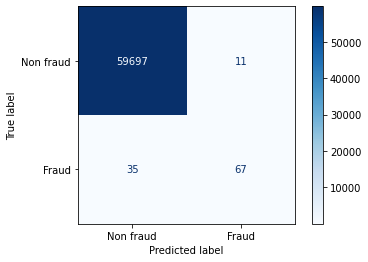

In [36]:
plot_confusion_matrix(lr_default, X_valid, y_valid,
                      display_labels=["Non fraud", "Fraud"],
                      values_format="d", cmap="Blues", ax=plt.gca());

Now let's rebuild our pipeline but using the `class_weight` argument and setting it as`class_weight={1:100}`. 

This is equivalent to saying "repeat every positive example 100x in the training set", but repeating data would slow down the code, whereas this doesn't.

In [37]:
lr_100 = LogisticRegression(random_state=12, max_iter=1000, class_weight={1:100})
lr_100.fit(X_train,y_train);

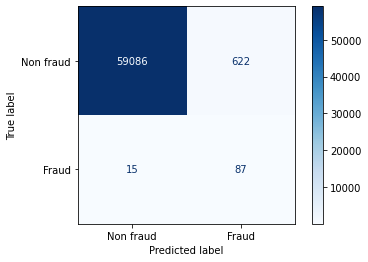

In [38]:
plot_confusion_matrix(lr_100, X_valid, y_valid,
                      display_labels=["Non fraud", "Fraud"], 
                      values_format="d", cmap="Blues", ax=plt.gca());

Notice that we now have reduced false negatives and predicted more true positives this time.

But, as a consequence, we pay a price since now we are also increasing false positives. 

We can also set `class_weight="balanced"`.

This sets the weights so that the classes are "equal".

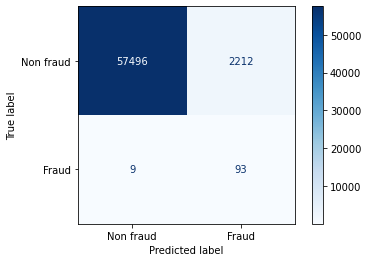

In [39]:
lr_balanced = LogisticRegression(random_state=12, max_iter=1000, class_weight="balanced")
lr_balanced.fit(X_train,y_train);


plot_confusion_matrix(lr_balanced, X_valid, y_valid,
                      display_labels=["Non fraud", "Fraud"], 
                      values_format="d", cmap="Blues", ax=plt.gca());

Again, we have reduced the number of false negatives and increased the number of true positives but we have many more false positives now!

#### Are we doing better with `class_weight="balanced"`?

Let's compare some metrics and find out. 

In [40]:
lr_default.score(X_valid, y_valid)

0.99923089784317

In [41]:
lr_balanced.score(X_valid, y_valid)

0.9628657415147969

Changing the class weight will **generally reduce accuracy**.

The original model was trying to maximize accuracy. Now you're telling it to do something different.

But we know now that accuracy isn't the only metric that matters.

Let's explain why this happens. 

Since there are so many more negative examples than positive ones, false-positives affect accuracy much more than false negatives.

Thus, precision matters a lot more than recall in this accuracy calculation.

So, the default method trades off a lot of recall for a bit of precision.

We are paying a "fee" in precision for a greater recall value. 

## Let's Practice

<img src="imgs/Q_cm.png"  width = "60%" alt="404 image" />

Use the diagram above to answer the next .... questions.

1\. How many examples did the model of this matrix correctly label as "Guard"?   
2\. If **Forward** is the positive label, how many ***false-positive*** values are there?   
3\. How many examples does the model incorrectly predict?   
4\. What is the recall of the confusion matrix assuming that **Forward** is the positive label?    
5\. What is the precision of the confusion matrix assuming that **Forward** is the positive label?   
6\. What is the f1 score assuming that **Forward** is the positive label?   


**True or False:**       

7\. In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means it's not).    
8\. In medical diagnosis, high recall is more important than high precision.    
9\. The weighted average gives equal importance to all classes.    
10\. Setting `class_weight={1:100}` will make the second class label 100 times the weight of the first class.    

```{admonition} Solutions!
:class: dropdown

1. 26
2. 4
3. 7
4. $0.86 = 19/22$
5. $0.83 = 19/23$
6. $ 2 * \frac{0.86 * 0.83}{0.86 + 0.83} = 0.84$
7. True
8. True
9. False
10. False
```

## Regression Metrics 

For this part, since we need to use data that corresponds to a regression problem, we are bringing back our [California housing dataset](https://www.kaggle.com/harrywang/housing). 

We want to predict the median house value for different locations.

In [42]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)


train_df = train_df.assign(rooms_per_household = train_df["total_rooms"]/train_df["households"],
                           bedrooms_per_household = train_df["total_bedrooms"]/train_df["households"],
                           population_per_household = train_df["population"]/train_df["households"])
                        
test_df = test_df.assign(rooms_per_household = test_df["total_rooms"]/test_df["households"],
                         bedrooms_per_household = test_df["total_bedrooms"]/test_df["households"],
                         population_per_household = test_df["population"]/test_df["households"])
                         
train_df = train_df.drop(columns=['total_rooms', 'total_bedrooms', 'population'])  
test_df = test_df.drop(columns=['total_rooms', 'total_bedrooms', 'population']) 

In [43]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]
X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

numeric_features = [ "longitude", "latitude",
                     "housing_median_age",
                     "households", "median_income",
                     "rooms_per_household",
                     "bedrooms_per_household",
                     "population_per_household"]
                     
categorical_features = ["ocean_proximity"]

X_train.head()

longitude  latitude  housing_median_age  households  median_income  \
6051     -117.75     34.04                22.0       602.0         3.1250   
20113    -119.57     37.94                17.0        20.0         3.4861   
14289    -117.13     32.74                46.0       708.0         2.6604   
13665    -117.31     34.02                18.0       285.0         5.2139   
14471    -117.23     32.88                18.0      1458.0         1.8580   

      ocean_proximity  rooms_per_household  bedrooms_per_household  \
6051           INLAND             4.897010                1.056478   
20113          INLAND            17.300000                6.500000   
14289      NEAR OCEAN             4.738701                1.084746   
13665          INLAND             5.733333                0.961404   
14471      NEAR OCEAN             3.817558                1.004801   

       population_per_household  
6051                   4.318937  
20113                  2.550000  
14289                  2.057910  
13665                  3.154386  
14471                  4.323045

We are going to bring in our previous pipelines and fit our model. 

In [44]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
           ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = make_column_transformer(
(numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features), 
    remainder='passthrough')

pipe = make_pipeline(preprocessor, KNeighborsRegressor())
pipe.fit(X_train, y_train);

As you know, since we aren't doing classification anymore, so we can't just check for equality. 

In [45]:
predicted_y = pipe.predict(X_train) 

In [46]:
predicted_y

array([111740., 117380., 187700., ..., 271420., 265180.,  60860.])

In [47]:
y_train.values

array([113600., 137500., 170100., ..., 286200., 412500.,  59300.])

In [48]:
predicted_y == y_train

6051     False
20113    False
14289    False
13665    False
14471    False
         ...  
7763     False
15377    False
17730    False
15725    False
19966    False
Name: median_house_value, Length: 18576, dtype: bool

We need a score that reflects how right/wrong each prediction is or how close we are to the actual numeric value.

We are going to discuss 4 different ones lightly but, if you want to see more regression metrics in detail, you can refer to the [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). 

###  Mean squared error (MSE)

Mean Squared Error is a common measure.


$$MSE = \frac{1}{n} \displaystyle\sum_{i=1}^{n} (y_i - {\tilde{y_i}})^2$$

$$MSE = \frac{1}{\text{total samples}} \displaystyle\sum_{i=1}^{\text{total samples}} (\text{true}_i - {\text{predicted}_i})^2$$

We calculate this by calculating the difference between the predicted and actual value, square it and sum all these values for every example in the data. 

The higher the MSE, the worse the model performs.

In [49]:
predicted_y

array([111740., 117380., 187700., ..., 271420., 265180.,  60860.])

In [50]:
((y_train - predicted_y)**2).mean()

2570054492.048064

Perfect predictions would have MSE=0.

We can see that by using `y_train` instead of `predicted_y` which demonstrates how we get 0 as a result. 

In [51]:
((y_train - y_train)**2).mean()

0.0

We can use `mean_squared_error` from `sklearn.metrics` again instead of calculating this ourselves. 

In [52]:
from sklearn.metrics import mean_squared_error 

In [53]:
mean_squared_error(y_train, predicted_y)

2570054492.048064

#### The disadvantages

If we look at MSE here, it's huge and unreasonable. 

Is this score good or bad?

Unlike classification, in regression, our target has units. 

In this case, our target column is the median housing value which is in dollars. 

That means that the mean squared error is in dollars$^2$. 

The score also depends on the scale of the targets. 

If we were working in cents instead of dollars, our MSE would be 10,000 X (100<sup>2</sup>) higher!

### Quick recap on $R^2$

We've seen this before!

This is the score that `sklearn` uses by default when you call `.score()` so we've already seen $R^2$ in our regression problems. 

You can <a href="https://en.wikipedia.org/wiki/Coefficient_of_determination" target="_blank">read about it here</a> but we are going to just give you the quick notes. 

Intuition: mean squared error, but flipped where higher values mean a better measurement.

It's normalized so the max is 1.

We can use the default scoring from `.score()` or we can calculate $R^2$ using `r2_score` from `sklearn.metrics`

In [54]:
from sklearn.metrics import r2_score

When you call `fit` it minimizes MSE / maximizes R<sup>2</sup> (or something like that) by default.

Just like how accuracy isn't always what you want in classification, $R^2$ isn't always what you want in regression!


Another important thing to note is that we can reverse MSE but not R<sup>2</sup> (optional).

In [55]:
print(mean_squared_error(y_train, predicted_y))
print(mean_squared_error(predicted_y, y_train))

2570054492.048064
2570054492.048064


In [56]:
print(r2_score(y_train, predicted_y))
print(r2_score(predicted_y, y_train))

0.8059396097446094
0.742915970464153


### Root mean squared error  (RMSE)

Remember the MSE we had before was in $dollars^2$. A more relatable metric would be the root mean squared error, or RMSE. 

This is the square root of $MSE$.

$$RMSE = \sqrt{MSE}$$



$$MSE = \sqrt{\frac{1}{n} \displaystyle\sum_{i=1}^{n} (y_i - {\tilde{y_i}})^2}$$

$$MSE =  \sqrt{\frac{1}{\text{total samples}} \displaystyle\sum_{i=1}^{\text{total samples}} (\text{true}_i - {\text{predicted}_i})^2}$$

In [57]:
mean_squared_error(y_train, predicted_y)

2570054492.048064

In [58]:
np.sqrt(mean_squared_error(y_train, predicted_y))

50695.704867849156

This now has the units in dollars.  Instead of 2 billion dollars squared, our error measurement is around $50,000.

Let's plot the predicted vs the true housing prices here.

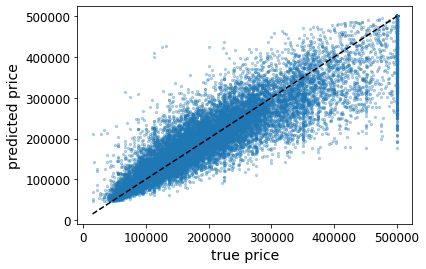

In [59]:
df = pd.DataFrame(y_train).assign(predicted = predicted_y).rename(columns = {'median_house_value': 'true'})
df = pd.DataFrame(y_train).assign(predicted = predicted_y).rename(columns = {'median_house_value': 'true'})
plt.scatter(y_train, predicted_y, alpha=0.3, s = 5)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, '--k');
plt.xticks(fontsize= 12);
plt.yticks(fontsize= 12);
plt.xlabel("true price", fontsize=14);
plt.ylabel("predicted price", fontsize=14);

When we plot our predictions versus the examples' actual value, we can see cases where our prediction is way off.

Points under the line $y=x$ means we're under-predicting price, points over the line means we're over-predicting price.

*Question: Is an error of \$30,000 acceptable?*   

- For a house worth \$600k, it seems reasonable! That's a 5% error.
- For a house worth \$60k, that is terrible. It's a 50% error.

So how can we adjust to this? 

...Enter **MAPE**!

### MAPE - Mean Absolute Percent Error (MAPE)

We can calculate a percentage error for each example. Now the errors are both positive (predict too high) and negative (predict too low).

We can look at the absolute percent error which now shows us how far off we were independent of direction. 

Like MSE, we can take the average over all the examples. This is called **Mean Absolute Percent Error (MAPE)**.

Ok, this is quite interpretable. We can see that on average, we have around 18% error in our predicted median housing valuation.

We can calculate a percentage error for each example. Now the errors are both positive (predict too high) and negative (predict too low).

In [60]:
percent_errors = (predicted_y - y_train)/y_train * 100.
percent_errors.head()

6051     -1.637324
20113   -14.632727
14289    10.346855
13665     6.713070
14471   -10.965854
Name: median_house_value, dtype: float64

We can look at the absolute percent error which now shows us how far off we were independent of direction. 

In [61]:
np.abs(percent_errors).head()

6051      1.637324
20113    14.632727
14289    10.346855
13665     6.713070
14471    10.965854
Name: median_house_value, dtype: float64

And like MSE, we can take the average over all the examples. 

In [62]:
np.abs(percent_errors).mean()

18.192997502985218

This is called **Mean Absolute Percent Error (MAPE)**.

This is quite interpretable. We can see that on average, we have around 18% error in our predicted median housing valuation.

## Let's Practice 

1\. Which measurement will have units which are the square values of the target column units?    
2\. For which of the following is it possible to have negative values?    
3\. Which measurement is expressed as a percentage?    
4\. Calculate the MSE from the values given below.     


|Observation | True Value | Predicted Value |
|------------|------------|-----------------|
|0           | 4          | 5               |
|1           | 12         | 10              |
|2           | 6          | 9               |
|3           | 9          | 8               |
|4           | 3          | 3               |


**True or False:**   

5\. We can still use recall and precision for regression problems but now we have other measurements we can use as well.      
6\. A lower RMSE value indicates a better model.      
7\. In regression problems, calculating $R^2$  using `r2_score()` and `.score()` (with default values) will produce the same results.     

```{admonition} Solutions!
:class: dropdown

1. $MSE$
2. $R^2$
3. $MAPE$
4. 3
5. False
6. True
7. True

```

## Passing Different Scoring Methods

We now know about all these metrics; how do we implement them? 

We are lucky because it's relatively easy and can be applied to both classification and regression problems. 

Let's start with regression and our regression measurements. 

This means bringing back our California housing dataset.

In [63]:
X_train.head()

longitude  latitude  housing_median_age  households  median_income  \
6051     -117.75     34.04                22.0       602.0         3.1250   
20113    -119.57     37.94                17.0        20.0         3.4861   
14289    -117.13     32.74                46.0       708.0         2.6604   
13665    -117.31     34.02                18.0       285.0         5.2139   
14471    -117.23     32.88                18.0      1458.0         1.8580   

      ocean_proximity  rooms_per_household  bedrooms_per_household  \
6051           INLAND             4.897010                1.056478   
20113          INLAND            17.300000                6.500000   
14289      NEAR OCEAN             4.738701                1.084746   
13665          INLAND             5.733333                0.961404   
14471      NEAR OCEAN             3.817558                1.004801   

       population_per_household  
6051                   4.318937  
20113                  2.550000  
14289                  2.057910  
13665                  3.154386  
14471                  4.323045

And our pipelines. 

This time we are using $k$-nn.

In [64]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
           ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = make_column_transformer(
(numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features), 
    remainder='passthrough')

pipe_regression = make_pipeline(preprocessor, KNeighborsRegressor())

### Cross-validation

Normally after building our pipelines, we would now either do cross-validation or hyperparameter tuning but let's start with the `cross_validate()` function. 

All the possible scoring metrics that this argument accepts are available [here in the sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter). 

In this case, if we wanted the RMSE measure, we would specify `neg_mean_squared_error` and the negated value of the metric will be returned in our dataframe. 

In [65]:
pd.DataFrame(cross_validate(pipe_regression,
                            X_train, y_train, 
                            return_train_score=True,
                      #      scoring = 'neg_root_mean_squared_error')
            ))

fit_time  score_time  test_score  train_score
0  0.039957    0.289924    0.695818     0.801659
1  0.032168    0.278022    0.707483     0.799575
2  0.033430    0.300306    0.713788     0.795944
3  0.037170    0.280229    0.686938     0.801232
4  0.031539    0.219956    0.724608     0.832498

In [66]:
pd.DataFrame(cross_validate(pipe_regression,
                            X_train, y_train, 
                            return_train_score=True,
                            scoring = 'neg_root_mean_squared_error')
            )

fit_time  score_time    test_score   train_score
0  0.036687    0.292240 -62462.584290 -51440.540539
1  0.033530    0.250330 -63437.715015 -51263.979666
2  0.030526    0.250198 -62613.202523 -51758.817852
3  0.029188    0.274914 -64204.295214 -51343.743586
4  0.028573    0.208082 -59217.838633 -47325.157312

Sometimes they don't have the scoring measure that we want and that's ok.

We can make our own using the `make_scorer` from sklearn. 

First, we import `make_scorer` from `Sklearn`. 

In [67]:
from sklearn.metrics import make_scorer

Next, we can make a function calculating our desired measurement. In this case, we are making a function that has the true and predicted values as inputs and then returns the Mean Absolute percentage Error.

In [68]:
def mape(true, pred):
    return 100.*(np.abs((pred - true)/true)).mean()

We can turn this into something that the `scoring` argument will understand by putting our created MAPE function as an input argument in `make_scorer()`. 

Now when we cross-validate, we can specify the new `mape_scorer` as our measure. 

In [69]:
mape_scorer = make_scorer(mape)

Now when we cross-validate, we can specify the new `mape_scorer` as our measure. 

In [70]:
pd.DataFrame(cross_validate(
    pipe_regression, X_train, y_train, return_train_score=True, scoring=mape_scorer))

fit_time  score_time  test_score  train_score
0  0.039827    0.394224   22.709732    18.420969
1  0.062865    0.408991   22.754570    18.469125
2  0.032953    0.245034   22.236869    18.674964
3  0.031604    0.255892   23.016666    18.510766
4  0.038290    0.278134   21.033519    16.951021

Now our cross-validation returns percentages! 

We can also return multiple scoring measures together by making a dictionary and then specifying the dictionary in the `scoring` argument. 

In [71]:
scoring={
    "r2": "r2",
    "mape_score": mape_scorer,
    "neg_rmse": "neg_root_mean_squared_error",    
    "neg_mse": "neg_mean_squared_error",    
}

In [72]:
pd.DataFrame(cross_validate(pipe_regression,
                            X_train, y_train,
                            return_train_score=True, 
                            scoring=scoring))

fit_time  score_time   test_r2  train_r2  test_mape_score  \
0  0.037458    0.299782  0.695818  0.801659        22.709732   
1  0.031972    0.261208  0.707483  0.799575        22.754570   
2  0.031364    0.261568  0.713788  0.795944        22.236869   
3  0.030382    0.263205  0.686938  0.801232        23.016666   
4  0.032217    0.221644  0.724608  0.832498        21.033519   

   train_mape_score  test_neg_rmse  train_neg_rmse  test_neg_mse  \
0         18.420969  -62462.584290   -51440.540539 -3.901574e+09   
1         18.469125  -63437.715015   -51263.979666 -4.024344e+09   
2         18.674964  -62613.202523   -51758.817852 -3.920413e+09   
3         18.510766  -64204.295214   -51343.743586 -4.122192e+09   
4         16.951021  -59217.838633   -47325.157312 -3.506752e+09   

   train_neg_mse  
0  -2.646129e+09  
1  -2.627996e+09  
2  -2.678975e+09  
3  -2.636180e+09  
4  -2.239671e+09

This returns a validation and training score for each measurement! 

### What about hyperparameter tuning?

We can do exactly the same thing we saw above with `cross_validate()` but instead with `GridSearchCV` and `RandomizedSearchCV`. 

In [73]:
param_grid = {"kneighborsregressor__n_neighbors": [2, 5, 50, 100]}

In [74]:
grid_search = GridSearchCV(pipe_regression, param_grid, cv=5, 
                           return_train_score=True, n_jobs=-1, 
                           scoring= mape_scorer);
grid_search.fit(X_train, y_train);

In [75]:
grid_search.best_params_

{'kneighborsregressor__n_neighbors': 100}

In [76]:
grid_search.best_score_

24.63336199650092

Ok wait hold on, let's think about this again. 

The way that `best_params_` works is that it selects the parameters where the scoring measure selected is the highest. The problem with that is MAPE is an error, and we want the parameter with the lowest value, not the highest. 

We use the argument `greater_is_better` to specify if larger values make it a better score or a worse score. The default for this is `True`. 

We can create a new MAPE scorer by adding the argument `greater_is_better=False` in `make_scorer`.  

In [77]:
neg_mape_scorer = make_scorer(mape, greater_is_better=False)

In [78]:
grid_search = GridSearchCV(pipe_regression, param_grid, cv=5,
                           return_train_score=True, n_jobs=-1,
                           scoring= neg_mape_scorer);
grid_search.fit(X_train, y_train);

Now our `best_params_` will return the parameters will the lowest MAPE (least amount of error). 

In [79]:
grid_search.best_params_

{'kneighborsregressor__n_neighbors': 5}

In [80]:
grid_search.best_score_

-22.350271196169718

That's better! 

### ... and with Classification? 

Let's bring back our credit card data set and build our pipeline.

In [81]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)

X_train, y_train = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

We can use `class_weight='balanced'` in our classifier...

In [82]:
dt_model = DecisionTreeClassifier(random_state=123, class_weight='balanced')

In [83]:
param_grid = {"max_depth": scipy.stats.randint(low=1, high=100)}

... and tune our model for the thing we care about. 

In this case, we are specifying the `f1` score.

In [84]:
grid_search = RandomizedSearchCV(dt_model, param_grid, cv=5, return_train_score=True,
                           verbose=1, n_jobs=-1, scoring= 'f1', n_iter = 6)
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [85]:
grid_search.best_params_

{'max_depth': 91}

In [86]:
grid_search.best_score_

0.7190834822443745

This returns the `max_depth` value that results in the highest `f1` score, not the `max_depth` with the highest accuracy. 

## Let's Practice

**True or False:**     
1\. The `scoring` argument only accepts `str` inputs.   
2\. We are limited to the scoring measures offered from sklearn.    
3\. If we specify the scoring method in `GridSearchCV` and `RandomizedSearchCV`, `best_param_`  will return the parameters with the best specified measure.*    

```{admonition} Solutions!
:class: dropdown

1. False
2. False
3. True

```

## Let's Practice - Coding

Let’s bring back the Pokémon dataset that we saw previously. 

This time let's look at the distribution of our target variable `legendary`.

In [87]:
from sklearn.model_selection import train_test_split


pk_df = pd.read_csv('data/pokemon.csv')

train_df, test_df = train_test_split(pk_df, test_size=0.2, random_state=1)

X_train_big = train_df.drop(columns=['legendary'])
y_train_big = train_df['legendary']
X_test = test_df.drop(columns=['legendary'])
y_test = test_df['legendary']

X_train, X_valid, y_train, y_valid = train_test_split(X_train_big, 
                                                      y_train_big, 
                                                      test_size=0.3, 
                                                      random_state=123)

print(y_train.value_counts())

0    405
1     43
Name: legendary, dtype: int64


Let's do cross-validation and look at the scores from cross-validation of not just accuracy, but precision and recall and the f1 score as well.


1. Build a pipeline containing the column transformer and an SVC model and set `class_weight="balanced"` in the SVM classifier. 
2. Perform cross-validation using cross-validate on the training split using the scoring measures accuracy, precision, recall and f1.
3. Save the results in a dataframe.

## What We've Learned Today

- The components of a confusion matrix.
- How to calculate precision, recall, and f1-score.
- How to implement the `class_weight` argument.
- Some of the different scoring metrics used in assessing regression problems; MSE, RMSE, $R^2$, MAPE.
- How to apply different scoring functions with `cross_validate`, `GridSearchCV` and `RandomizedSearchCV`.